## DSAI HW1 Peak Load Forecasting by LSTM ##
### Chien, Hsin-Yen (RE6071088) ###
Institute of Data Science

### Package ###
pandas==0.23.4  
numpy==1.15.4  
matplotlib==3.0.2  
scikit-learn==0.20.2  
Keras==2.2.4  
tensorflow==1.12.0  
h5py==2.9.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

### Training Data ###
* Using TaiPower's peak_load data from 2017.01.02 to 2018.12.31  
* Plot a time-series by matplotlib

In [2]:
data1 = pd.read_csv('electric_power2017-2018.csv', index_col='date', encoding='utf-8')
data1.index = data1.index.map(pd.to_datetime)
data1.head()

,peak_load(MW)
date,
2017-01-02,24483
2017-01-03,28131
2017-01-04,28485
2017-01-05,28336
2017-01-06,28002


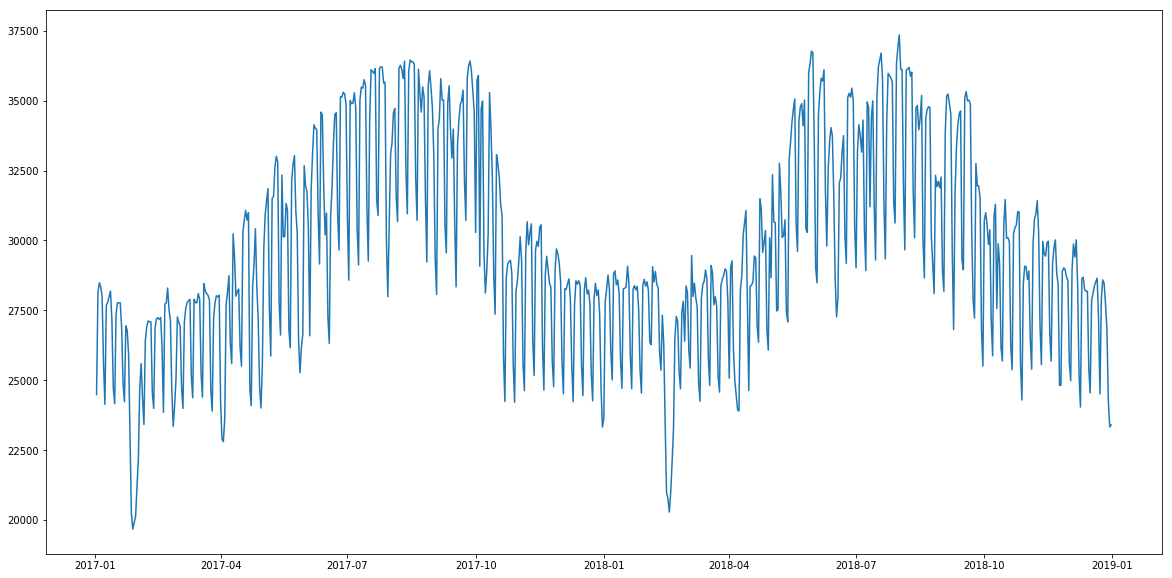

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(data1)
plt.show()

### Feature Scaling ###
* Normalization
* To fit the model better

In [4]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set = sc.fit_transform(data1)

### Setting training set ###
* Use 30 days data before the week we want to predict.

In [5]:
X_train = []
y_train = []
for i in range(30, len(training_set)-7):
    X_train.append(training_set[i-30:i, 0])
    y_train.append(training_set[i:i+7, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### RNN: LSTM ###
LSTM is the better method then others to predict a time-series.
* Use Keras to model my LSTM model.
* The following are my setting,
  1. batch size = 32
  2. epochs = 100
  3. 1 input layer, 2 hidden layers and 1 output layer. Each layer has 100 units except output layer.
  4. Loss function: Mean Square Error
  5. Optimize by RMSprop
  6. 10% Validation

In [6]:
# Import Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from keras.optimizers import RMSprop

batch_size = 32
epochs = 100

# Initialising the RNN
model = Sequential()

model.add(LSTM(100, input_shape=(30, 1), return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(7))

model.summary()

model.compile(loss='mean_squared_error', optimizer=RMSprop())

model.fit(X_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose=0,
          validation_split=0.1)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 202,307
Trainable params: 202,307
Non-trainable params: 0
_________________________________________________________________


### Visualising the model by training data ###

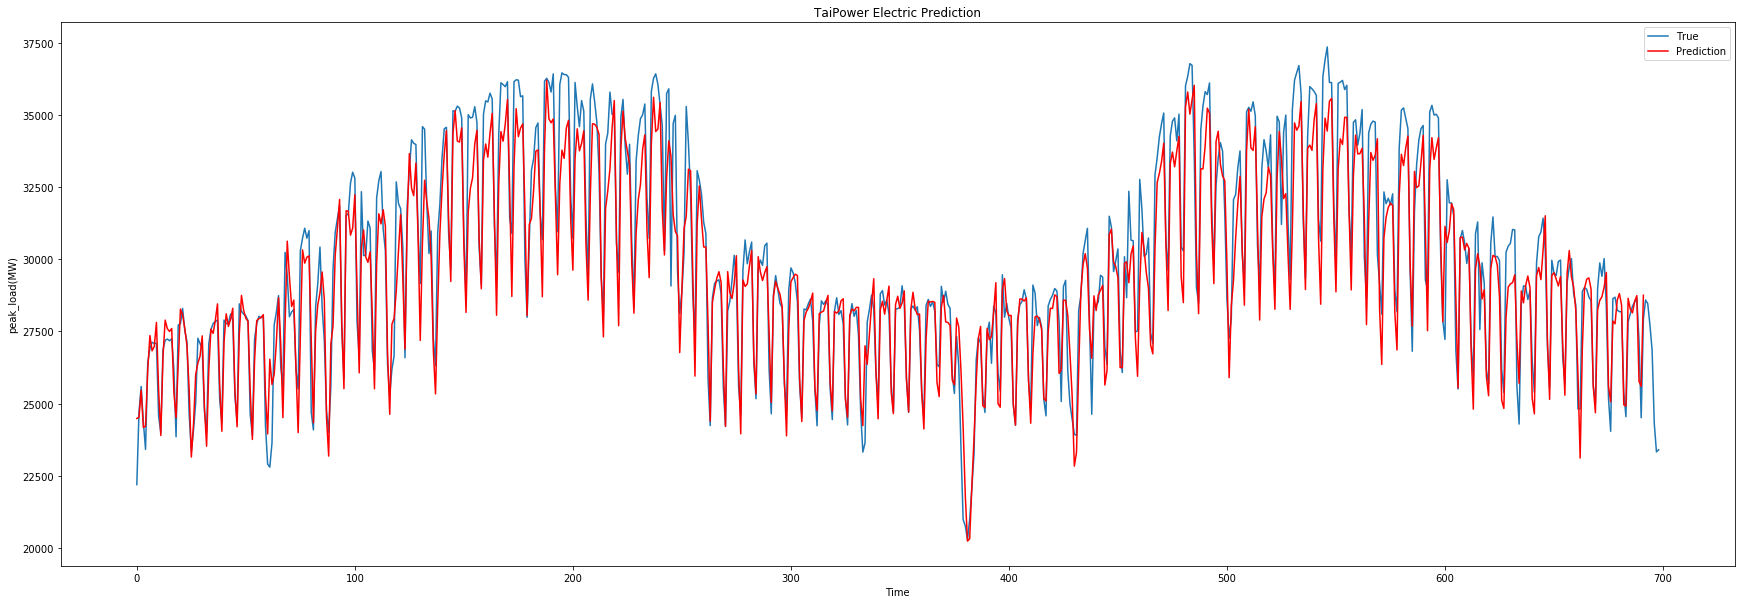

In [7]:
predict = model.predict(X_train)
predict = sc.inverse_transform(predict)
prediction = []
for i in range(len(X_train)):
    prediction.append(predict[i][0])
prediction

# Visualising the model
plt.figure(figsize=(30, 10))
plt.plot(data1.values[30:,], label = 'True')
plt.plot(prediction, color = 'red', label = 'Prediction')
plt.title('TaiPower Electric Prediction')
plt.xlabel('Time')
plt.ylabel('peak_load(MW)')
plt.legend()
plt.show()

### Test Data 1: Predict peak_load in 20190320-20190326 ###
* Use the data in 20190218-20190319, totally 30 days.
* Evaluation: By Root Mean Square Error(RMSE)

In [8]:
# Test data 1: 20190218-20190319 Predict 20190324-20190331
data2 = pd.read_csv('electric_power2019.csv', index_col='日期', encoding='utf-8')
data2.index = data2.index.map(pd.to_datetime)
test_set = sc.transform(data2)
X_test = []
for i in range(52, 82):
    X_test.append(test_set[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (1, 30, 1)) 
y_test = data2.values[82:89]

predict = model.predict(X_test)
predict = sc.inverse_transform(predict)
y_pred = []
for i in range(7):
    y_pred.append(predict[0][i])
print('Prediction:', [value for value in y_pred])

Prediction: [25732.502, 29258.977, 28678.61, 28720.482, 28735.822, 28687.666, 25344.705]


In [9]:
# RMSE
RMSE = 0
for i in range(7):
    RMSE = RMSE + np.square(y_pred[i]-y_test[i])
RMSE = np.sqrt(RMSE)
print('RMSE = %.4f'% round(float(RMSE), 4))

RMSE = 2140.7391


### Visualising the results ###

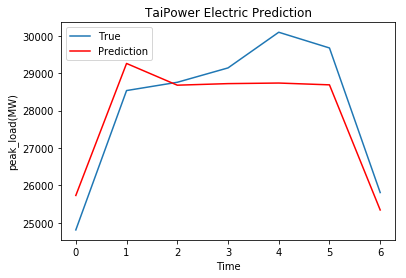

In [10]:
# Visualising the results
plt.plot(y_test, label = 'True')
plt.plot(y_pred, color = 'red', label = 'Prediction')
plt.title('TaiPower Electric Prediction')
plt.xlabel('Time')
plt.ylabel('peak_load(MW)')
plt.legend()
plt.show()

### Test Data 2 (Target): Predict peak_load in 20190402-20190408 ###
* Use the data in 20190303-20190401, totally 30 days.
* Evaluation: By Root Mean Square Error(RMSE)

In [11]:
# Test data 2: 20190303-20190401 Predict 20190402-20190408
data2 = pd.read_csv('electric_power2019.csv', index_col='日期', encoding='utf-8')
data2.index = data2.index.map(pd.to_datetime)
test_set = sc.transform(data2)
X_test = []
for i in range(len(test_set)-30, len(test_set)):
    X_test.append(test_set[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (1, 30, 1)) 

predict = model.predict(X_test)
predict = sc.inverse_transform(predict)
final_prediction = []
for i in range(7):
    final_prediction.append(predict[0][i])
print('Prediction:', [value for value in final_prediction])

Prediction: [28122.596, 27920.58, 28102.268, 28447.191, 25970.662, 23864.193, 27692.348]


### Save the model & results ###

In [14]:
# Save Model & result
model.save('Model.h5')
submit= pd.read_csv('submission.csv')
submit['peak_load(MW)']=final_prediction
submit.to_csv('submission.csv', index=False)
